### Prepate Dataset

In [ ]:
import pandas as pd
import re

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/DATA/train_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/DATA/test_data.csv')

df = df_train.append(df_test, ignore_index=True)

<ipython-input-2-80140d584b68>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_test, ignore_index=True)


In [ ]:
df_train.shape

(9900, 2)

In [ ]:
df_test.shape

(1100, 2)

In [ ]:
df.head()

,tweets,labels
0,tempat yang nyaman untuk berkumpul dengan tema...,positive
1,"memang banyak bacot sih , omongan doang gede b...",negative
2,"buat yang berkunjung ke bandung , yang ingin m...",positive
3,restoran menyajikan makanan khas sunda yang en...,positive
4,"kalau travelling ke bandung , wajib makan bata...",positive


In [ ]:
df.shape

(11000, 2)

In [ ]:
df.labels.value_counts()

positive    6416
negative    3436
neutral     1148
Name: labels, dtype: int64

### Text Cleansing

In [ ]:
def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    string = re.sub('\n',' ', string)
    string = re.sub('rt',' ', string)
    string = re.sub(r'[0-9]+', '', string)
    string = re.sub('user',' ', string)
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',string)
    string = re.sub(r'#', '', string)
    string = re.sub(r',','',string)
    string = re.sub(r'[0-9]+', '', string)
    string = re.sub('  +',' ', string)
    string = re.sub('[^0-9a-zA-Z]+', ' ', string)
    string = re.sub('  +',' ', string) 
    return string

In [ ]:
df['text_clean'] = df.tweets.apply(cleansing)

In [ ]:
df.head()

,tweets,labels,text_clean
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,tempat yang nyaman untuk berkumpul dengan tema...
1,"memang banyak bacot sih , omongan doang gede b...",negative,memang banyak bacot sih omongan doang gede boc...
2,"buat yang berkunjung ke bandung , yang ingin m...",positive,buat yang berkunjung ke bandung yang ingin men...
3,restoran menyajikan makanan khas sunda yang en...,positive,restoran menyajikan makanan khas sunda yang en...
4,"kalau travelling ke bandung , wajib makan bata...",positive,kalau travelling ke bandung wajib makan batago...


In [ ]:
df.tail()

,tweets,labels,text_clean
10995,mau petik stroberi nya tetapi ternyata sedang ...,positive,mau petik stroberi nya tetapi ternyata sedang ...
10996,yang benar saja masa nomer whatsapp saya di bl...,negative,yang benar saja masa nomer whatsapp saya di bl...
10997,food court yang memiliki berbagai macam piliha...,positive,food cou yang memiliki berbagai macam pilihan ...
10998,"gorengan basi dihidangkan , selera murahan",negative,gorengan basi dihidangkan selera murahan
10999,negara indonesia terancam bangkrut .,negative,negara indonesia terancam bangkrut


Sortir data dan label berdasarkan sentimen

In [ ]:
neg = df.loc[df['labels'] == 'negative'].text_clean.tolist()
neu = df.loc[df['labels'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['labels'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['labels'] == 'negative'].labels.tolist()
neu_label = df.loc[df['labels'] == 'neutral'].labels.tolist()
pos_label = df.loc[df['labels'] == 'positive'].labels.tolist()

In [ ]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [ ]:
#df_train['text_clean'] = df_train['tweets'].apply(lambda x: cleansing(x))
#df_test['text_clean'] = df_test['tweets'].apply(lambda x: cleansing(x))

### Feature Extraction

Setelah itu melakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow.

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


### Prepare train & test datasets/Splitting Dataset

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [ ]:
from sklearn.model_selection import train_test_split

file = open("/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### Training

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [ ]:
embed_dim = 100

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 86, 100)           10000000  
                                                                 
 conv1d (Conv1D)             (None, 82, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 10,065,451
Trainable params: 10,065,451
Non-trainable params: 0
____________________________________________

### Evaluation

In [ ]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 8ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       685
           1       0.79      0.75      0.77       233
           2       0.90      0.96      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.88      0.89      0.88      2200



In [ ]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 8ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       685
           1       0.79      0.78      0.78       233
           2       0.92      0.94      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.88      0.89      0.88      2200

69/69 [==============================] - 1s 7ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       685
           1       0.80      0.70      0.75       233
           2       0.91      0.95      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.88      0.89      0.88      2200

69/69 [==============================] - 1s 7ms/step
Training ke- 3
              precision    recall 

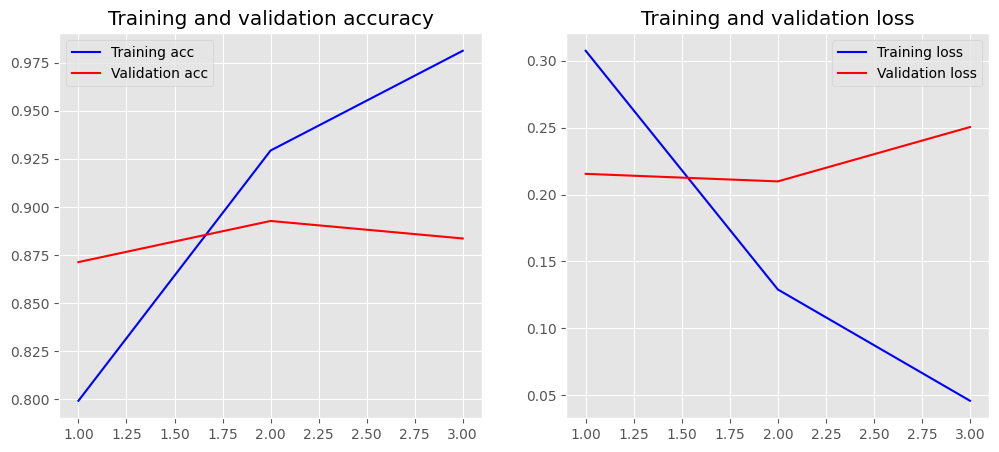

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/modelcnn.h5')
print("Model has created!")

Model has created!


In [ ]:
# ROC scores
from sklearn.metrics import roc_auc_score

roc_auc_cnn = round(roc_auc_score(y_test, y_pred),4)
print('ROC AUC:', roc_auc_cnn)

ROC AUC: 0.959


### Predict

In [ ]:
import re 
from keras.models import load_model

input_text = """
saham BBRI pada kuartal kedua naik
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('/content/drive/MyDrive/Colab Notebooks/platinum_challenge/cnn/modelcnn.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 69ms/step
Text:   saham bbri pada kuartal kedua naik 
Sentiment:  neutral
